In [ ]:
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
print(os.getcwd())
os.chdir('/content/drive/My Drive/1006')
print(os.getcwd())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/content
/content/drive/My Drive/1006


In [ ]:
class SparseModel(nn.Module):
  def __init__(self, hdim):
    super(SparseModel, self).__init__()
    self.hdim = hdim
    w = torch.zeros((hdim, hdim))
    torch.nn.init.xavier_normal_(w)
    w.requires_grad = True
    self.weights = nn.Parameter(w)

  def forward(self, input):
    x = torch.matmul(input, self.weights)
    return x

def custom_loss(output, input):
  return 0.5 * torch.square(torch.norm(input-output, p='fro')) / input.size()[1]

def run_model(data, learning_rate, num_epochs, lmbda, verbosity=0):
  model = SparseModel(data.size()[1]).cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  loss_list = []
  prev_eval_loss = 99999
  for epoch in range(num_epochs):
    model.train()
    # ===================forward=====================
    output = model(data.float())
    reg21 = torch.sum(torch.norm(model.weights, p=2, dim=1))
    loss = custom_loss(output, data) + lmbda * reg21
    if epoch%100==0 and verbosity==1:
      print('L1 norm of L2 norm of weights: ', reg21.item())
    # ===================backward====================
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # ===================log=======================
    if epoch%100==0 and verbosity==1:
      print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.item()))
    model.eval()
    eval_loss = F.l1_loss(model(data.float()), data.float()).item()
    loss_list.append(eval_loss)
    if epoch%100==0 and verbosity==1:
      print('Eval loss: ', eval_loss)
      print()
    if eval_loss > prev_eval_loss:
      break
    prev_eval_loss = eval_loss
  print('Eval loss: ', eval_loss)
  print('Stopping epoch: ', epoch)
  return model, loss_list

def visualize_results(data, model, loss_list):
  plt.plot(loss_list)
  plt.show()
  res = model(data.float()).cpu().detach()
  plt.plot(data[:,1998].detach().cpu())
  plt.plot(res[:,1998], alpha=0.8)
  plt.show()
  plt.plot(data[:,113].detach().cpu())
  plt.plot(res[:,113], alpha=0.8)
  plt.show()
  plt.plot(data[:,4567].detach().cpu())
  plt.plot(res[:,4567], alpha=0.8)
  plt.show()
  plt.hist(data[:,5698].detach().cpu())
  plt.hist(res[:,5698], alpha=0.5)
  plt.show()
  plt.hist(data[:,123].detach().cpu())
  plt.hist(res[:,123], alpha=0.5)
  plt.show()
  plt.hist(data[:,4444].detach().cpu())
  plt.hist(res[:,4444], alpha=0.5)
  plt.show()

torch.Size([16, 8437])

Eval loss:  0.0005942204152233899
Stopping epoch:  3186
Time:  65.2335274219513


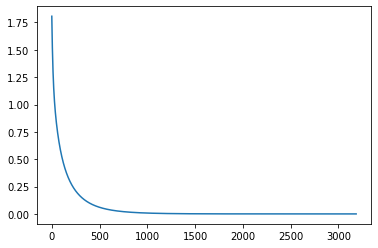

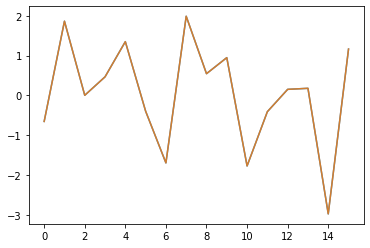

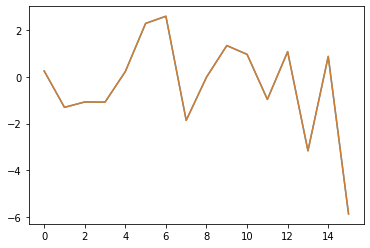

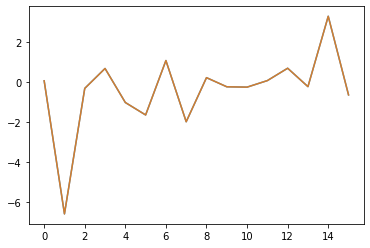

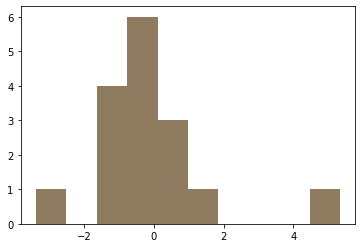

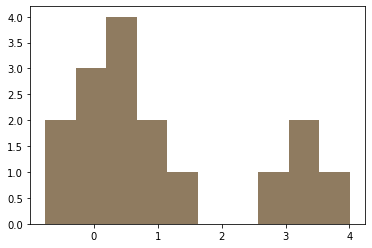

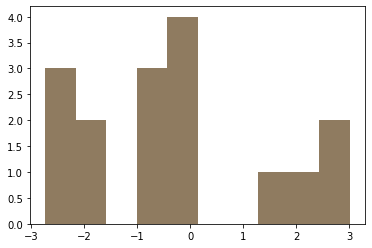

In [ ]:
# Read in data
data = pd.read_csv('eo_cvec_tsne16_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.005, num_epochs=30000, lmbda=0.001, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_cvec_tsne16_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([16, 8437])

Eval loss:  7.561066740890965e-05
Stopping epoch:  1106
Time:  22.887177228927612


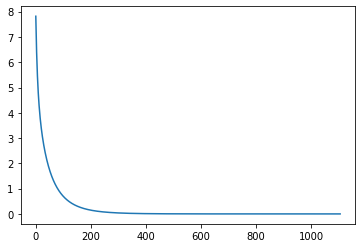

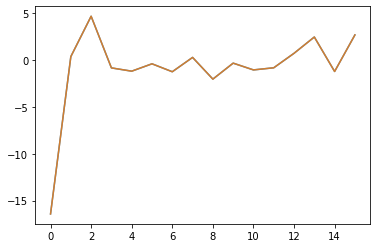

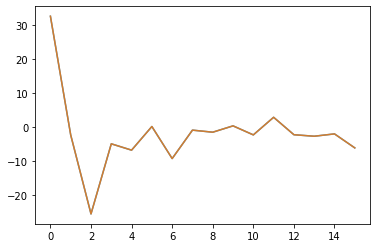

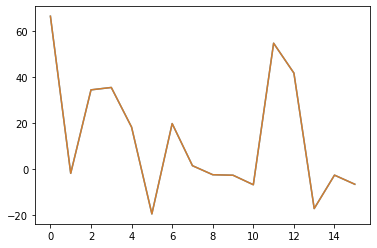

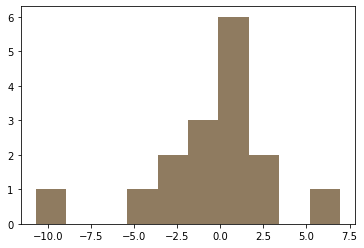

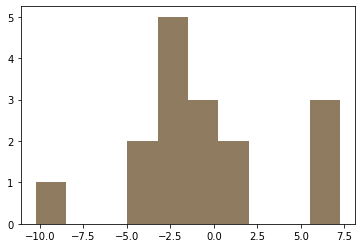

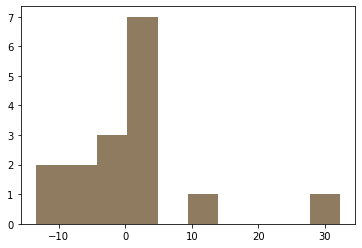

In [ ]:
# Read in data
data = pd.read_csv('eo_cvec_pca16_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.0005, num_epochs=30000, lmbda=0.001, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_cvec_pca16_bert_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([16, 8437])

Eval loss:  0.0011028896551579237
Stopping epoch:  49625
Time:  988.4154765605927


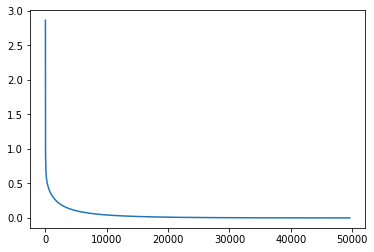

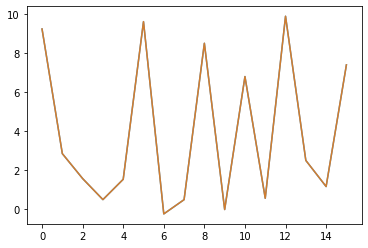

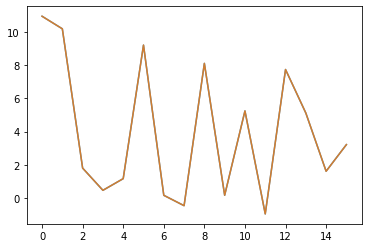

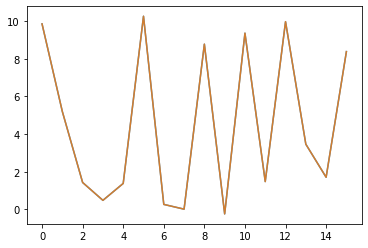

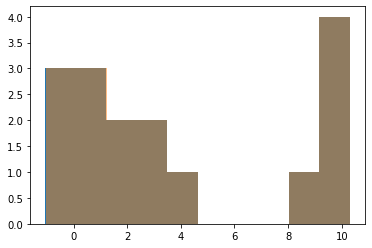

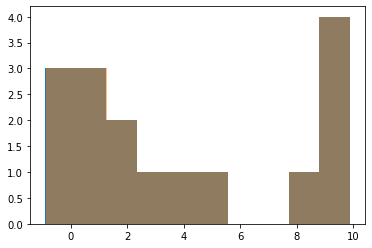

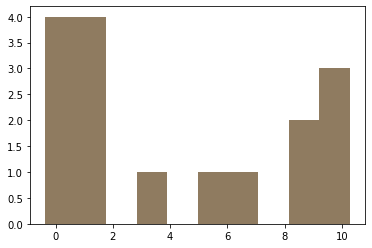

In [ ]:
# Read in data
data = pd.read_csv('eo_cvec_umap16_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.001, num_epochs=50000, lmbda=0.001, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_cvec_umap16_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([16, 8437])

Eval loss:  0.00013859586033504456
Stopping epoch:  58745
Time:  1169.1710352897644


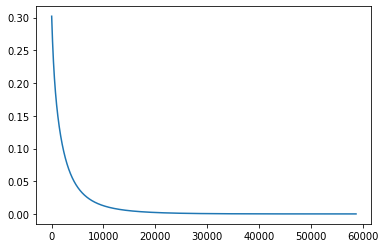

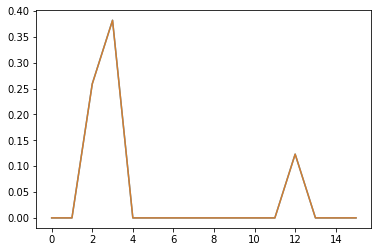

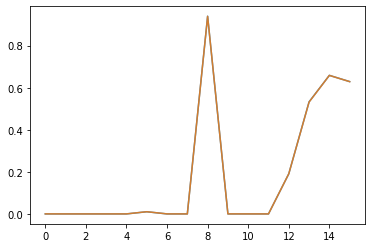

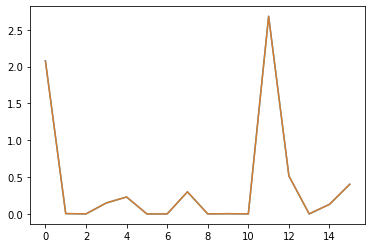

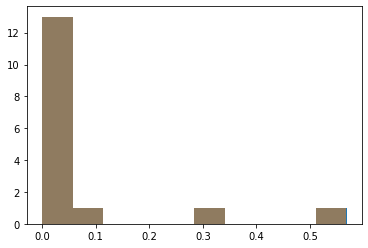

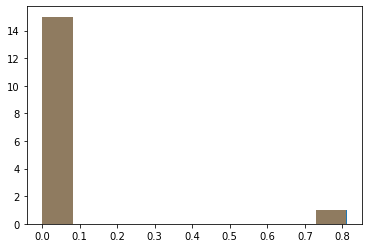

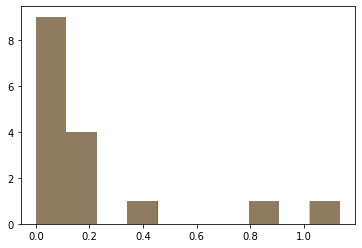

In [ ]:
# Read in data
data = pd.read_csv('eo_cvec_nmf16_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.005, num_epochs=60000, lmbda=0.0001, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_cvec_nmf16_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([768, 8437])

Eval loss:  0.035005874931812286
Stopping epoch:  11610
Time:  1585.130807876587


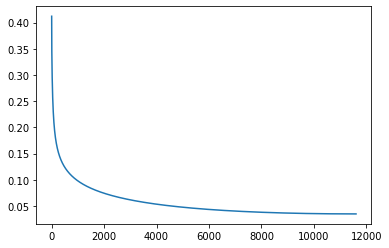

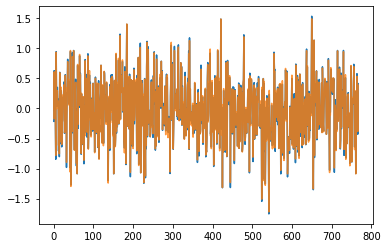

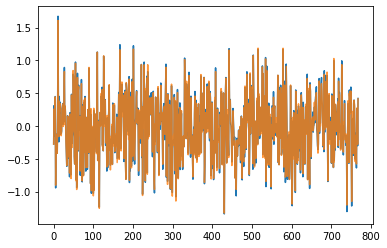

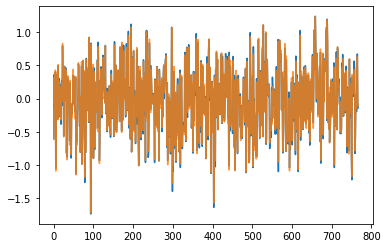

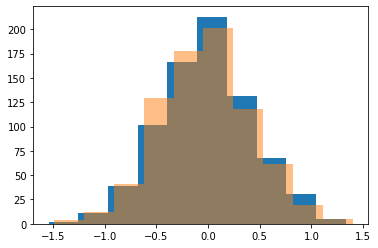

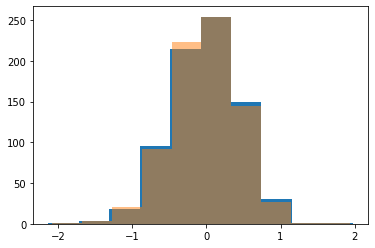

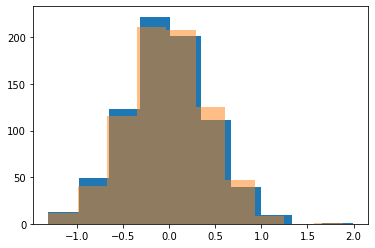

In [ ]:
# Read in data
data = pd.read_csv('eo_bert_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.01, num_epochs=20000, lmbda=0.005, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_bert_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([768, 8437])

Eval loss:  0.03270355984568596
Stopping epoch:  11832
Time:  1585.045403957367


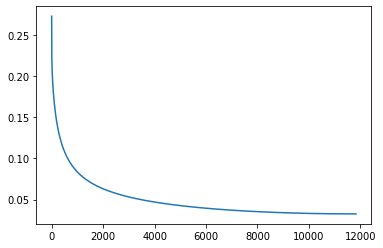

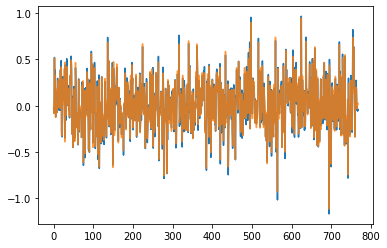

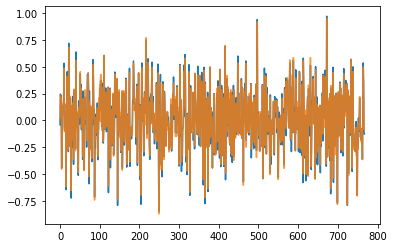

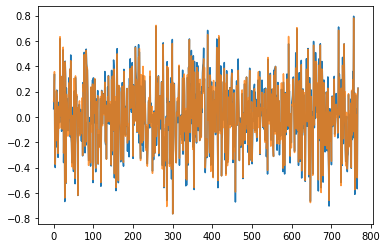

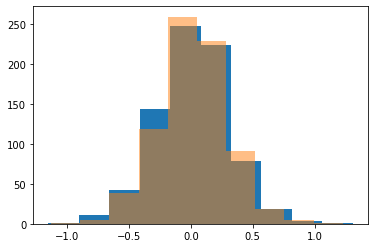

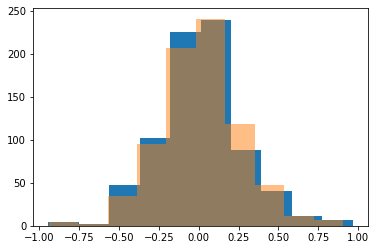

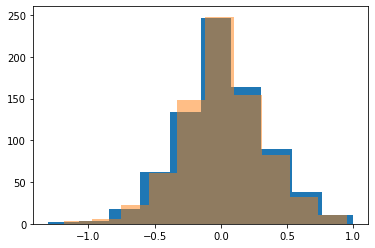

In [ ]:
# Read in data
data = pd.read_csv('eo_distil_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.01, num_epochs=20000, lmbda=0.005, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_distil_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([768, 8437])

Eval loss:  0.03432400897145271
Stopping epoch:  11449
Time:  1533.5511288642883


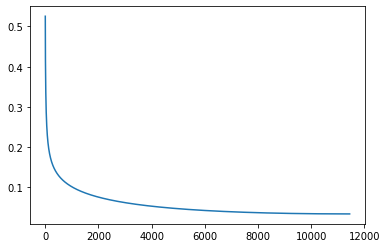

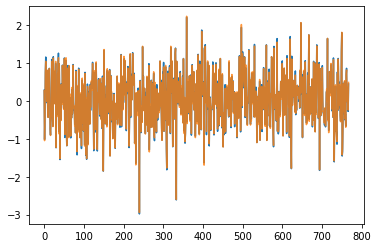

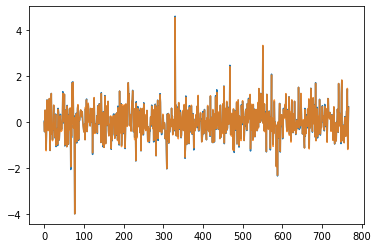

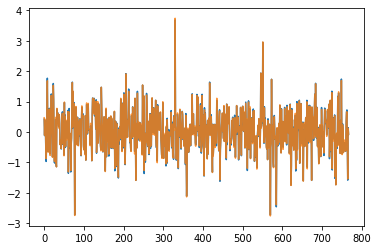

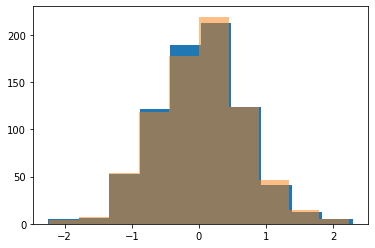

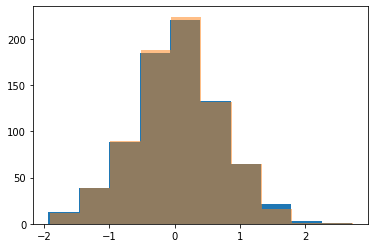

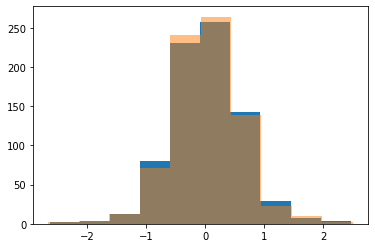

In [ ]:
# Read in data
data = pd.read_csv('eo_roberta_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.01, num_epochs=20000, lmbda=0.005, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_roberta_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([300, 8437])

Eval loss:  0.01764874905347824
Stopping epoch:  32241
Time:  1968.8636889457703


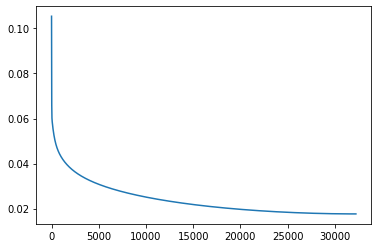

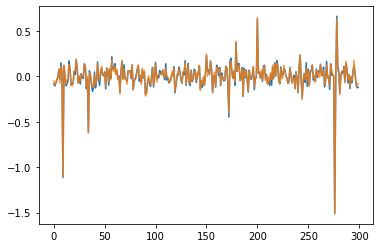

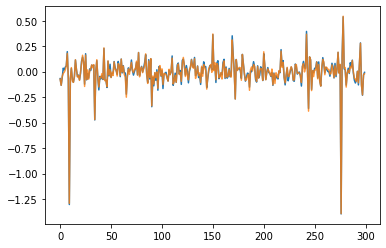

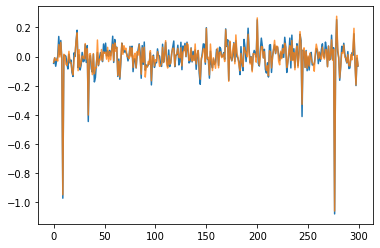

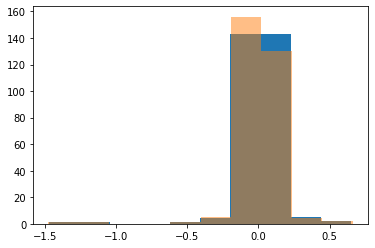

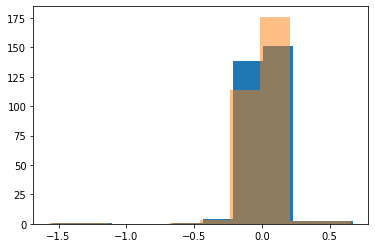

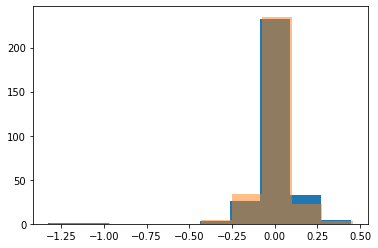

In [ ]:
# Read in data
data = pd.read_csv('eo_glove6B_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.01, num_epochs=40000, lmbda=0.002, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_glove6B_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

torch.Size([512, 8437])

Eval loss:  0.012359915301203728
Stopping epoch:  12777
Time:  1188.4107122421265


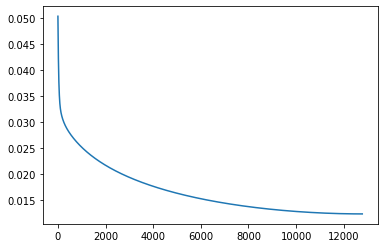

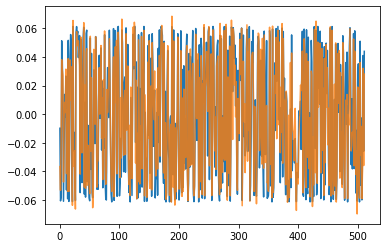

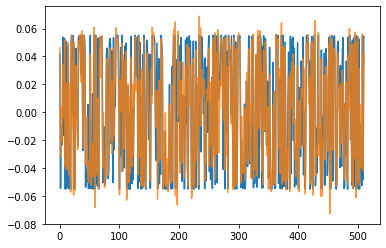

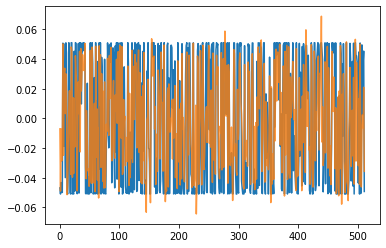

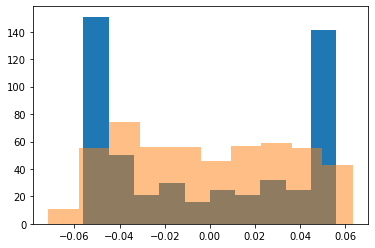

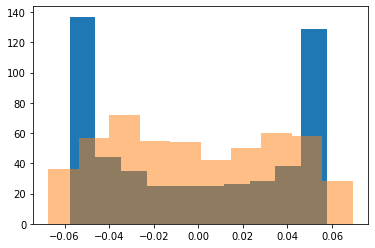

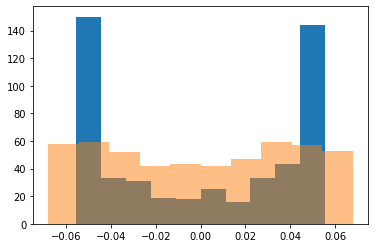

In [ ]:
# Read in data
data = pd.read_csv('eo_universal_train.csv', index_col=0)
data = torch.tensor(data.values)
data = data.T
print(data.shape)
print()
data = data.to(device)

# Run model
start_time = time.time()
model, loss_list = run_model(data, learning_rate=0.05, num_epochs=60000, lmbda=0.001, verbosity=0)
print("Time: ", time.time()-start_time)

# Print visualizations
visualize_results(data, model, loss_list)

# Save model weights
mw = model.weights.cpu().detach()
np.save('indices_eo_universal_recon', torch.argsort(torch.norm(mw, p=2, dim=1), descending=True).numpy()[:4200])

| Embedding type | Embedding length | learning rate | lambda |
| --- | --- | --- | --- |
| cvec_tsne16 | 16 | 0.005 | 0.001 |
| cvec_pca16 | 16 | 0.0005 | 0.001 |
| cvec_umap16 | 16 | 0.001 | 0.001 |
| cvec_nmf16 | 16 | 0.005 | 0.0001 |
| bert | 768 | 0.01 | 0.005 |
| distil | 768 | 0.01 | 0.005 |
| roberta | 768 | 0.01 | 0.005 |
| glove6B | 300 | 0.01 | 0.002 |
| universal | 512 | 0.05 | 0.001 |